# Analysis of drifting grating stimulus

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import pickle
from scipy.ndimage.filters import gaussian_filter
# from helper_functions import load_sim_results, get_activity, plot_PSTH #, get_single_cell_psths, detect_rate_peaks
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings('ignore', message='Mean of empty slice')

In [2]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/b87aac8d-b3d0-4e63-b589-560d826bbfdc/analyses/simulations.pkl'
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/6f0a9a9b-842b-4874-8b16-6c6010c07ace/analyses/simulations.pkl'
sims = pd.read_pickle(sims_file)

res_path = os.path.join(os.path.split(sims_file)[0], 'output')
save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

## Peak responses to drifting gratings

### Overview over all simulations

In [3]:
# Load PSTH results ("single_cell_psths" and "psth_peak_stats" launched with bbp-workflow)
psth_res_name = 'single_cell_psths'
peak_res_name = 'psth_peak_stats'
name_suffix = '__hex0_EXC'

psth_data = {}
peak_data = {}

cond_names = sims.index.names
for sim_idx, (cond, cfg_path) in enumerate(sims.iteritems()):
    cond_dict = dict(zip(cond_names, cond))
    sim_id = os.path.split(os.path.split(cfg_path)[0])[-1] # Subfolder name (i.e., 000, 001, ...)
    sim_spec = '__'.join([f'{k}_{v}' for k, v in cond_dict.items()]) # Sim conditions (e.g., sparsity_1.0__rate_bk_0.2__rate_max_10.0)

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    if os.path.exists(res_file):
        with open(res_file, 'rb') as f:
            res = pickle.load(f)
        psth_data[sim_idx] = res

    res_file = os.path.join(res_path, peak_res_name, f'{peak_res_name}{name_suffix}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    if os.path.exists(res_file):
        with open(res_file, 'rb') as f:
            res = pickle.load(f)
        peak_data[sim_idx] = res


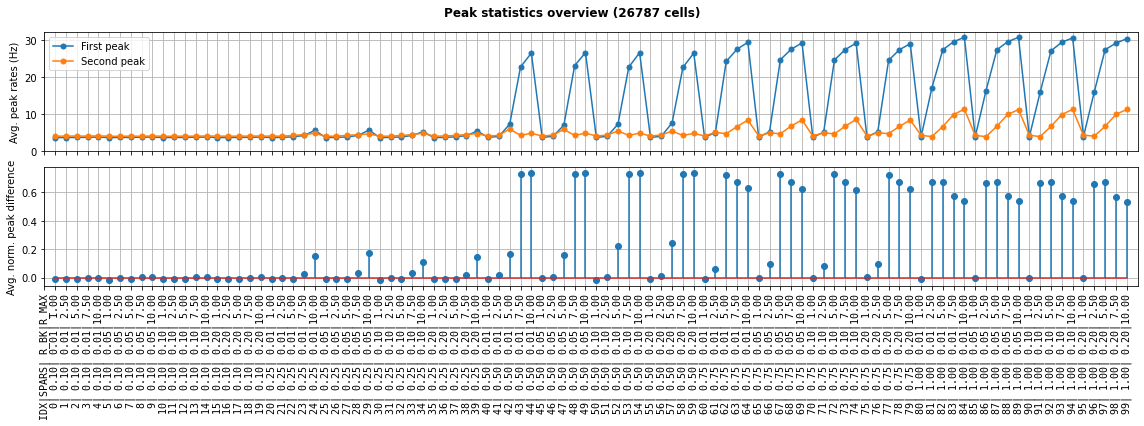

In [4]:
# Plot peak statistics overview
sim_ids = list(peak_data.keys())
peak_colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(16, 6))
peak_ratios = np.array([np.nanmean(peak_data[idx]['peak_ratio']) for idx in sim_ids])
peak_rates = np.array([[np.nanmean(peak_data[idx]['r1']), np.nanmean(peak_data[idx]['r2'])] for idx in sim_ids])
plt.subplot(2, 1, 1)
# plt.plot([np.arange(len(peak_data))] * 2, np.array(peak_rates).T, '.-')

# labels = []
# for idx, sim_idx in enumerate(sim_ids):
#     vparts = plt.violinplot([*filter(lambda x: np.isfinite(x), peak_data[sim_idx]['r1'])], positions=[idx - 0.25], showmeans=True)
#     for pc in vparts['bodies']:
#         pc.set_facecolor(peak_colors[0])
#     for partname in ('cbars','cmins','cmaxes', 'cmeans'):
#         vparts[partname].set_edgecolor(peak_colors[0])
#     vparts = plt.violinplot([*filter(lambda x: np.isfinite(x), peak_data[sim_idx]['r2'])], positions=[idx + 0.25], showmeans=True)
#     for pc in vparts['bodies']:
#         pc.set_facecolor(peak_colors[1])
#     for partname in ('cbars','cmins','cmaxes', 'cmeans'):
#         vparts[partname].set_edgecolor(peak_colors[1])
# labels.append((mpatches.Patch(color=peak_colors[0]), 'First peak'))
# labels.append((mpatches.Patch(color=peak_colors[1]), 'Second peak'))

plt.plot(np.arange(len(peak_data)), peak_rates[:, 0], '.-', color=peak_colors[0], markersize=10, clip_on=False, label='First peak')
plt.plot(np.arange(len(peak_data)), peak_rates[:, 1], '.-', color=peak_colors[1], markersize=10, clip_on=False, label='Second peak')

plt.xlim([-1, len(peak_data)])
xticks = [min(plt.xlim())] + np.arange(len(peak_data)).tolist()
plt.xticks(xticks, [])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Avg. peak rates (Hz)')
plt.grid()
plt.legend()
# plt.legend(*zip(*labels))

plt.subplot(2, 1, 2)
plt.stem(np.arange(len(peak_data)), peak_ratios)
# for idx, sim_idx in enumerate(sim_ids):
#     vparts = plt.violinplot([*filter(lambda x: np.isfinite(x), peak_data[sim_idx]['peak_ratio'])], positions=[idx], showmeans=True)
#     for pc in vparts['bodies']:
#         pc.set_facecolor('k')
#     for partname in ('cbars','cmins','cmaxes', 'cmeans'):
#         vparts[partname].set_edgecolor('k')

plt.xlim([-1, len(peak_data)])
head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_ids].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_ids[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_ids].index)]
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.ylabel('Avg. norm. peak difference')
plt.grid()

plt.suptitle(f'Peak statistics overview ({len(peak_data[sim_ids[0]]["peak_ratio"])} cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'peak_stat_overview.png'), dpi=300)
# plt.savefig(os.path.join(save_path, f'peak_stat_distr_overview.png'), dpi=300)
plt.show()

In [5]:
def plot_2d_maps(sims_index, data, x_name, y_name, group_name, data_label=None, title=None):
    x_idx = np.where([n == x_name for n in sims_index.names])[0][0]
    x_values = np.unique(sims_index.get_level_values(x_idx))
    y_idx = np.where([n == y_name for n in sims_index.names])[0][0]
    y_values = np.unique(sims_index.get_level_values(y_idx))
    group_idx = np.where([n == group_name for n in sims_index.names])[0][0]
    group_values = np.unique(sims_index.get_level_values(group_idx))

    plt.figure(figsize=(4 * len(group_values), 1 + 2 * len(y_values) / len(x_values)))
    for igrp in range(len(group_values)):
        plt.subplot(1, len(group_values), igrp + 1)
        grpval = group_values[igrp]
        res_map = np.full((len(y_values), len(x_values)), np.nan)
        for iy, yval in enumerate(y_values):
            for ix, xval in enumerate(x_values):
                res_idx = np.logical_and(np.logical_and(sims_index.get_level_values(y_idx) == yval, sims_index.get_level_values(x_idx) == xval), sims_index.get_level_values(group_idx) == grpval)
                res_map[iy, ix] = data[np.where(res_idx)[0][0]]
        plt.imshow(res_map, vmin=0.0, vmax=np.nanmax(data))
        plt.colorbar(label=data_label)
        plt.xticks(range(len(x_values)), x_values)
        plt.yticks(range(len(y_values)), y_values)
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title(f'{group_name}={grpval}', fontweight='bold')
        # plt.contour(range(len(x_values)), range(len(y_values)), res_map, cmap='Greys', levels=5) # Isolines (contour)
    plt.suptitle(title, fontweight='bold')
    plt.tight_layout()
    plt.show()

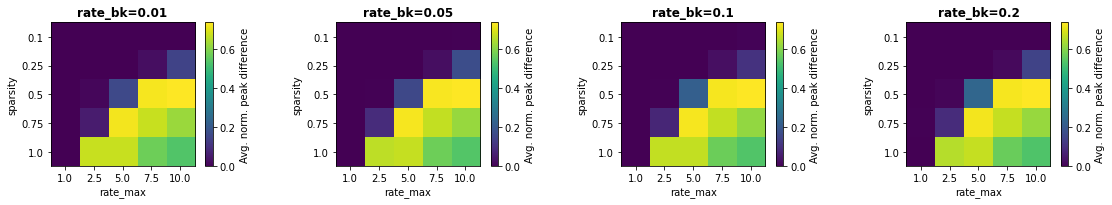

In [6]:
# Plot 2D maps of peak_ratios (rate_bk fixed)
plot_2d_maps(sims.index, peak_ratios, 'rate_max', 'sparsity', 'rate_bk', 'Avg. norm. peak difference')

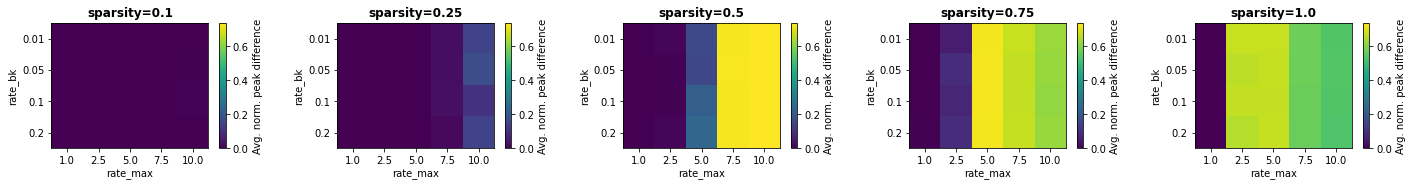

In [7]:
# Plot 2D maps of peak_ratios (sparsity fixed)
plot_2d_maps(sims.index, peak_ratios, 'rate_max', 'rate_bk', 'sparsity', 'Avg. norm. peak difference')

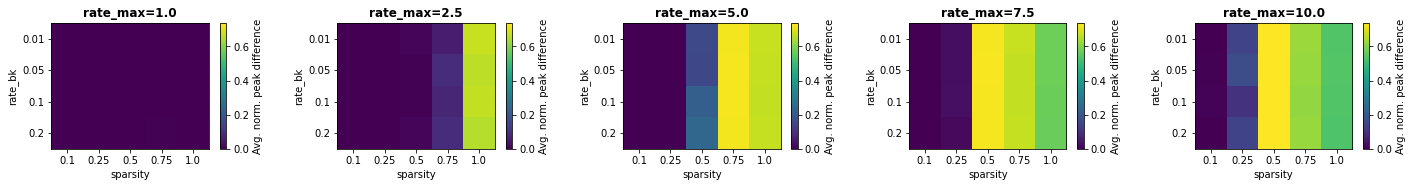

In [8]:
# Plot 2D maps of peak_ratios (rate_max fixed)
plot_2d_maps(sims.index, peak_ratios, 'sparsity', 'rate_bk', 'rate_max', 'Avg. norm. peak difference')

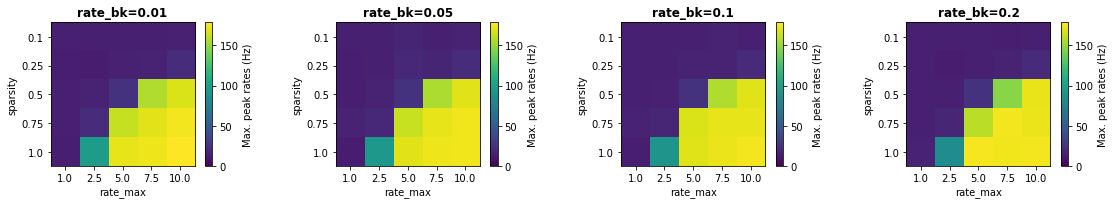

In [9]:
# Plot 2D maps of max. peak_rates (rate_bk fixed)
peak_rates_max = np.max(np.array([[np.nanmax(peak_data[idx]['r1']), np.nanmax(peak_data[idx]['r2'])] for idx in sim_ids]), 1)
plot_2d_maps(sims.index, peak_rates_max, 'rate_max', 'sparsity', 'rate_bk', 'Max. peak rates (Hz)')

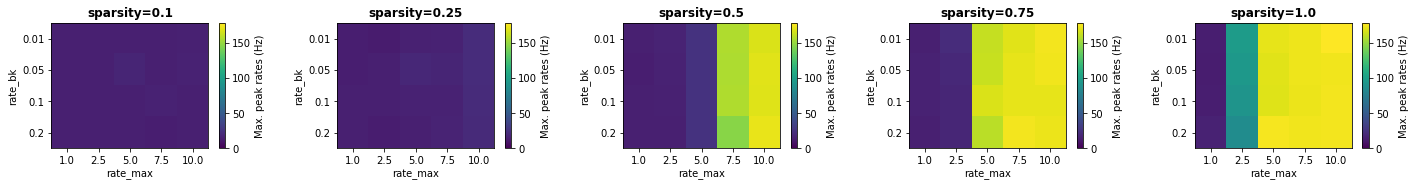

In [10]:
# Plot 2D maps of max. peak_rates (sparsity fixed)
plot_2d_maps(sims.index, peak_rates_max, 'rate_max', 'rate_bk', 'sparsity', 'Max. peak rates (Hz)')

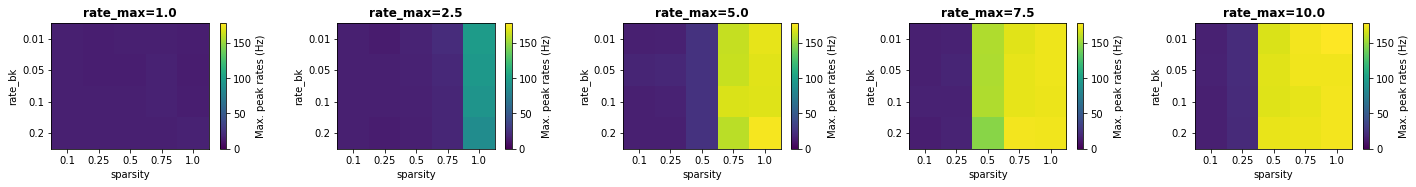

In [11]:
# Plot 2D maps of max. peak_rates (rate_max fixed)
plot_2d_maps(sims.index, peak_rates_max, 'sparsity', 'rate_bk', 'rate_max', 'Max. peak rates (Hz)')

In [12]:
# Compute tuning curves
resp_int = [0, 1000] # Response interval (ms) to extract time-averaged rates for tuning curves
base_int = [1000, 2000] # Baseline interval (ms) w/o stimulation
norm_contrast = 1.0 # Contrast level used for normalization

contrasts = None # Contrast levels
tuning_curves = [] # Normalized tuning curves
baselines = [] # Normalized baseline activities
gids = []
print('PROCESSING tuning curves...', end='')
for sim_idx in sim_ids:
    print(f' {sim_idx}', end='')

    if contrasts is None:
        contrasts = psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels']
    else:
        assert np.all(np.array(contrasts) == psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels'])

    t_rate = psth_data[sim_idx]['t_rate']
    num_patterns = int(len(psth_data[sim_idx]['rates']) / 2)
    patt_ind = list(range(num_patterns)) # Indices for raw contrast patterns
    opto_ind = list(range(num_patterns, 2 * num_patterns)) # Indices for contrast patterns with opto stim
    assert norm_contrast in contrasts, 'ERROR: Normalisation contrast level not found!'
    norm_idx = np.where(np.array(contrasts) == norm_contrast)[0][0]

    if len(gids) == 0:
        gids = psth_data[sim_idx]['gids']
    else:
        assert np.array_equal(gids, psth_data[sim_idx]['gids']), 'ERROR: GIDs mismatch across simulations!'
    num_cells = len(gids)
    avg_responses = []
    avg_baseline = []
    norm_responses = [] # Normalized rates based on max. rate at given norm_contrast level (w/o opto!)
    norm_baseline = [] # Normalized baseline rates based on max. rate at given norm_contrast level (w/o opto!)
    for gid in gids:
        resp_rates = []
        base_rates = []
        for p in range(2 * num_patterns):
            spike_trains = psth_data[sim_idx]['spike_trains'][p][gid]
            resp_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= resp_int[0], np.array(st) < resp_int[-1])) / np.diff(resp_int)[0] for st in spike_trains])
            base_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= base_int[0], np.array(st) < base_int[-1])) / np.diff(base_int)[0] for st in spike_trains])
        avg_responses.append(resp_rates)
        avg_baseline.append(base_rates)
        norm_rate = np.mean(resp_rates[norm_idx]) # Maximum rate used for normalization
        norm_responses.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in resp_rates[p]] for p in range(2 * num_patterns)])
        norm_baseline.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in base_rates[p]] for p in range(2 * num_patterns)])

    def resp_stat(responses, fct):
        """Computes statistics given by fct over response trials"""
        return np.array([[fct(r) if len(r) > 0 else np.nan for r in rr] for rr in responses])

    contr_resp_func = {}
    contr_resp_func.update({'mean': resp_stat(norm_responses, np.mean)})
    contr_resp_func.update({'std': resp_stat(norm_responses, np.std)})
    contr_resp_func.update({'N': resp_stat(norm_responses, len)})
    contr_resp_func.update({'sem': contr_resp_func['std'] / np.sqrt(contr_resp_func['N'])})

    baseline_activity = {}
    baseline_activity.update({'mean': resp_stat(norm_baseline, np.mean)})
    baseline_activity.update({'std': resp_stat(norm_baseline, np.std)})
    baseline_activity.update({'N': resp_stat(norm_baseline, len)})
    baseline_activity.update({'sem': baseline_activity['std'] / np.sqrt(baseline_activity['N'])})

    tuning_curves.append(contr_resp_func)
    baselines.append(baseline_activity)

#     # Single-cell tuning curves
#     plt.figure()
#     plt.plot(np.arange(num_patterns), contr_resp_func['mean'][:, patt_ind].T)
#     plt.xticks(np.arange(num_patterns), contrasts)
#     plt.grid()
#     plt.xlabel('Contrast')
#     plt.ylabel('Norm. rate')
#     plt.title(f'Contrast response function (N = {num_cells} neurons)', fontweight='bold')
#     plt.show()


PROCESSING tuning curves... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

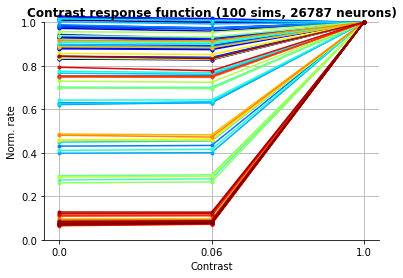

In [13]:
# Tuning curve overview over all simulations (mean over cells)
sim_colors = plt.cm.jet(np.linspace(0, 1, len(sim_ids)))
plt.figure()
for idx in range(len(sim_ids)):
    stim_mean = np.hstack([np.nanmean(baselines[idx]['mean'][:, patt_ind]), np.nanmean(tuning_curves[idx]['mean'][:, patt_ind], 0)])
    stim_sem = np.hstack([np.nanmean(baselines[idx]['sem'][:, patt_ind]), np.nanmean(tuning_curves[idx]['sem'][:, patt_ind], 0)])
    opto_mean = np.hstack([np.nanmean(baselines[idx]['mean'][:, opto_ind]), np.nanmean(tuning_curves[idx]['mean'][:, opto_ind], 0)])
    opto_sem = np.hstack([np.nanmean(baselines[idx]['sem'][:, opto_ind]), np.nanmean(tuning_curves[idx]['sem'][:, opto_ind], 0)])
    plt.plot(np.arange(num_patterns + 1), stim_mean, '.-', color=sim_colors[idx], clip_on=False)
    plt.plot(np.arange(num_patterns + 1), opto_mean, '.--', color=sim_colors[idx], clip_on=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(np.arange(num_patterns + 1), [0.0] + contrasts)
plt.grid()
plt.ylim((0.0, 1.0))
plt.xlabel('Contrast')
plt.ylabel('Norm. rate')
plt.title(f'Contrast response function ({len(sim_ids)} sims, {num_cells} neurons)', fontweight='bold')
plt.show()

In [14]:
# Compute robust per-neuron tuning curves
#   [Test over single cells if/how many tuning curves are present:
#    => 0.06 contrast above baseline by checking that SEM intervals non-overlapping]
def sem_non_overlap(tc, bl, contr_idx, bl_idx=None):
    """Test of SEMs between contrast tuning and baseline are non-overlapping"""
    if bl_idx is None:
        bl_idx = contr_idx # Default: Take baseline of selected contrast
    return (bl['mean'][:, bl_idx] + bl['sem'][:, bl_idx]) < (tc['mean'][:, contr_idx] - tc['sem'][:, contr_idx])

min_contr_idx = patt_ind[np.argmin(contrasts)]
max_contr_idx = patt_ind[np.argmax(contrasts)]
signif_stats = []
signif_count = []
ctrl_count = []
for idx, sim_idx in enumerate(sim_ids):
    tc = tuning_curves[idx]
    bl = baselines[idx]
    signif = sem_non_overlap(tc, bl, min_contr_idx)
    signif_ctrl1 = sem_non_overlap(bl, bl, min_contr_idx, max_contr_idx)
    signif_ctrl2 = sem_non_overlap(bl, bl, max_contr_idx, min_contr_idx)
    signif_stats.append(signif)
    signif_count.append(np.sum(signif))
    ctrl_count.append(np.mean([np.sum(signif_ctrl1), np.sum(signif_ctrl2)]))

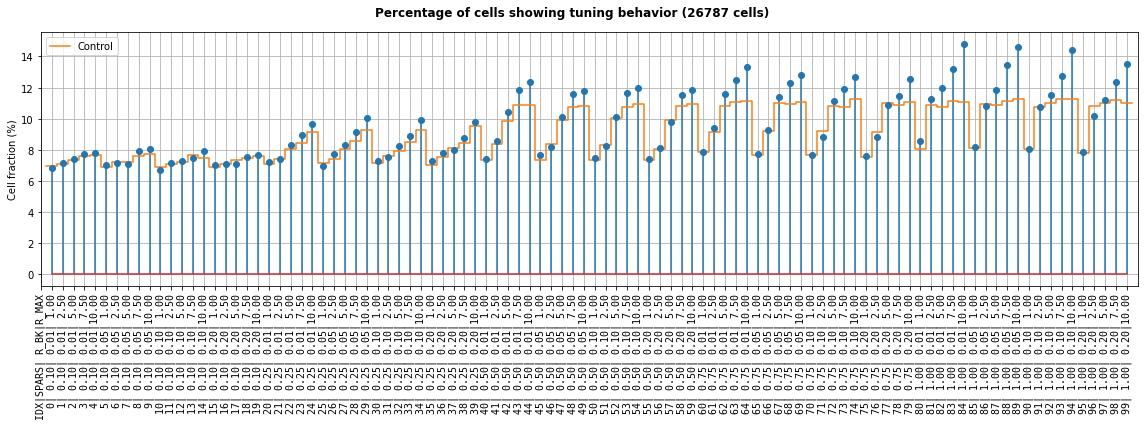

In [15]:
signif_pct = 100.0 * np.array(signif_count) / num_cells # Percentage of GIDs showing tuning behavior
ctrl_pct = 100.0 * np.array(ctrl_count) / num_cells # Percentage of GIDs showing tuning behavior (control)

plt.figure(figsize=(16, 6))
plt.step(np.arange(len(sim_ids) + 1) - 0.5, np.hstack([ctrl_pct[0], ctrl_pct]), color='tab:orange', label='Control')
plt.stem(np.arange(len(sim_ids)), signif_pct)

plt.xlim([-1, len(sim_ids)])
head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_ids].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_ids[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_ids].index)]
xticks = [min(plt.xlim())] + np.arange(len(peak_data)).tolist()
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.ylabel('Cell fraction (%)')
plt.grid()
plt.legend()
plt.suptitle(f'Percentage of cells showing tuning behavior ({num_cells} cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'cell_tuning_overview.png'), dpi=300)
plt.show()

/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/libraries/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/py-numpy-1.19.4-upzqna/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


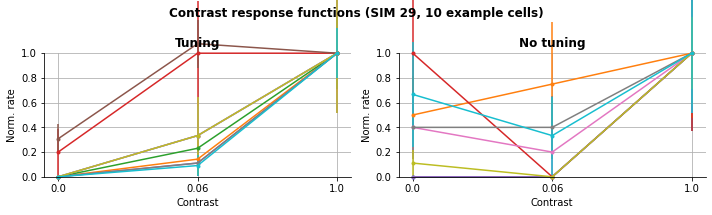

In [16]:
# Single-cell tuning curves (examples)
sel_sim = 29
tc = tuning_curves[sel_sim]
bl = baselines[sel_sim]
num_sel_gids = 10
plt.figure(figsize=(10, 3))
for sidx, sig_sel in enumerate([True, False]):
    plt.subplot(1, 2, sidx + 1)
    sel_gids = np.where(signif_stats[sel_sim] == sig_sel)[0][:num_sel_gids]
    for gid_idx in sel_gids:
        ebar = plt.errorbar(np.arange(num_patterns + 1), np.hstack([bl['mean'][gid_idx, min_contr_idx], tc['mean'][gid_idx, patt_ind]]), yerr=np.hstack([bl['sem'][gid_idx, min_contr_idx], tc['sem'][gid_idx, patt_ind]]), marker='.', clip_on=False)
        for bars in ebar[2]:
            bars.set_clip_on(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(np.arange(num_patterns + 1), [0.0] + contrasts)
    plt.grid()
    plt.ylim((0.0, 1.0))
    plt.xlabel('Contrast')
    plt.ylabel('Norm. rate')
    plt.title('Tuning' if sig_sel else 'No tuning', fontweight='bold')
plt.suptitle(f'Contrast response functions (SIM {sim_ids[sel_sim]}, {num_sel_gids} example cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'cell_tuning_example_SIM{sel_sim}.png'), dpi=300)
plt.show()

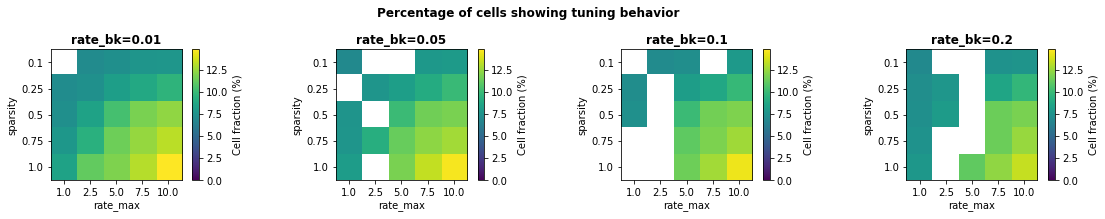

In [17]:
# Plot 2D maps of tuned cell fractions (rate_bk fixed)
signif_pct_above_ctrl = signif_pct.copy()
signif_pct_above_ctrl[signif_pct <= ctrl_pct] = np.nan
plot_2d_maps(sims.index, signif_pct_above_ctrl, 'rate_max', 'sparsity', 'rate_bk', 'Cell fraction (%)', 'Percentage of cells showing tuning behavior')

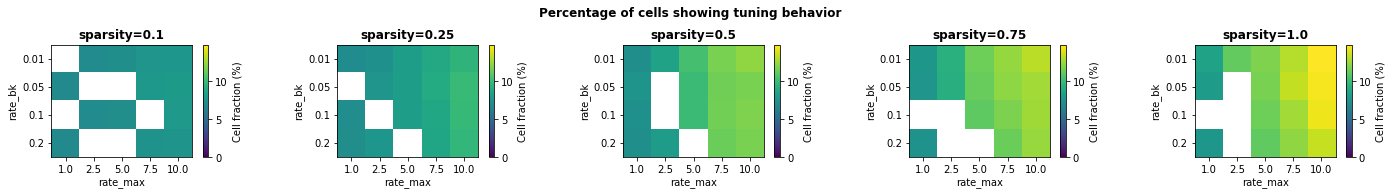

In [18]:
# Plot 2D maps of tuned cell fractions (sparsity fixed)
plot_2d_maps(sims.index, signif_pct_above_ctrl, 'rate_max', 'rate_bk', 'sparsity', 'Cell fraction (%)', 'Percentage of cells showing tuning behavior')

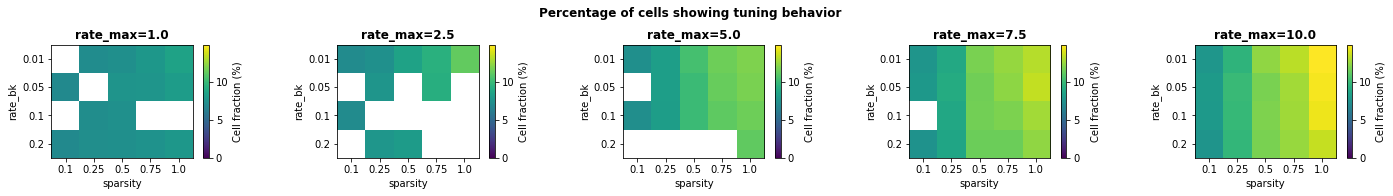

In [19]:
# Plot 2D maps of tuned cell fractions (rate_max fixed)
plot_2d_maps(sims.index, signif_pct_above_ctrl, 'sparsity', 'rate_bk', 'rate_max', 'Cell fraction (%)', 'Percentage of cells showing tuning behavior')

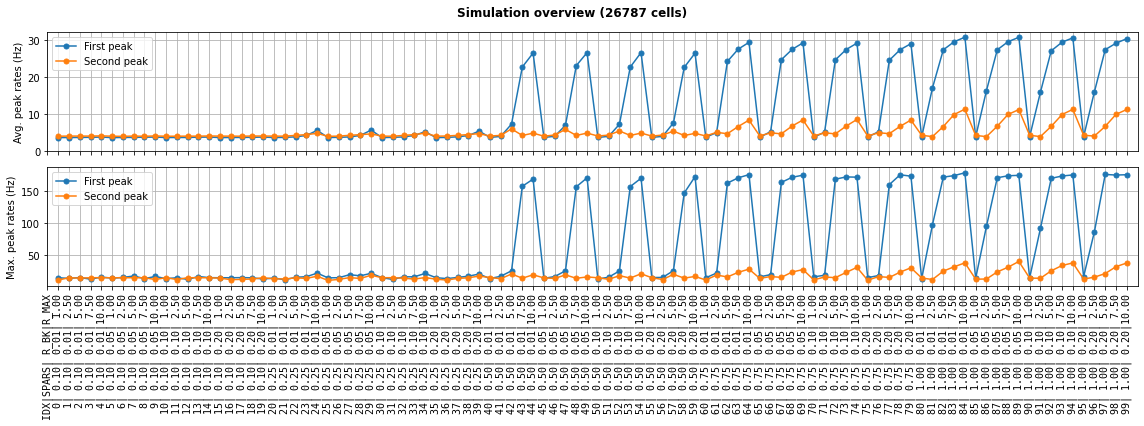

In [20]:
# Peak rates overview (avg/max)
plt.figure(figsize=(16, 6))
peak_rates = np.array([[np.nanmean(peak_data[idx]['r1']), np.nanmean(peak_data[idx]['r2'])] for idx in sim_ids])
peak_rates_max = np.array([[np.nanmax(peak_data[idx]['r1']), np.nanmax(peak_data[idx]['r2'])] for idx in sim_ids])

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(peak_data)), peak_rates[:, 0], '.-', color=peak_colors[0], markersize=10, clip_on=False, label='First peak')
plt.plot(np.arange(len(peak_data)), peak_rates[:, 1], '.-', color=peak_colors[1], markersize=10, clip_on=False, label='Second peak')

plt.xlim([-1, len(sim_ids)])
xticks = [min(plt.xlim())] + np.arange(len(peak_data)).tolist()
plt.xticks(xticks, [])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Avg. peak rates (Hz)')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(peak_data)), peak_rates_max[:, 0], '.-', color=peak_colors[0], markersize=10, clip_on=False, label='First peak')
plt.plot(np.arange(len(peak_data)), peak_rates_max[:, 1], '.-', color=peak_colors[1], markersize=10, clip_on=False, label='Second peak')

plt.xlim([-1, len(sim_ids)])
head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_ids].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_ids[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_ids].index)]
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.ylabel('Max. peak rates (Hz)')
plt.grid()
plt.legend()

plt.suptitle(f'Simulation overview ({num_cells} cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'peak_rates_overview.png'), dpi=300)
plt.show()

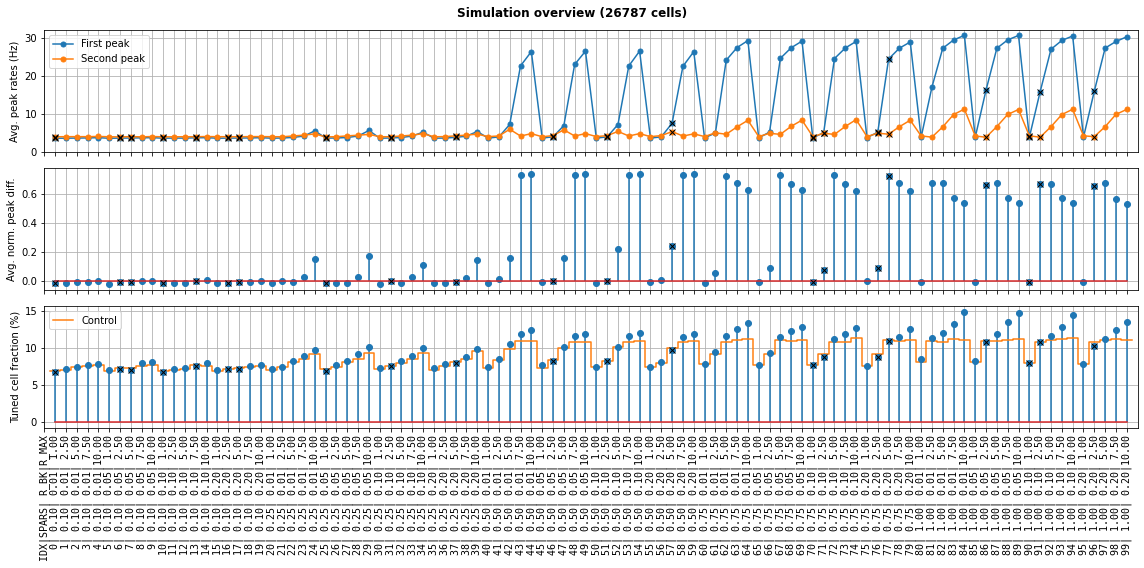

In [21]:
# Combining all panels
plt.figure(figsize=(16, 8))
peak_ratios = np.array([np.nanmean(peak_data[idx]['peak_ratio']) for idx in sim_ids])
peak_rates = np.array([[np.nanmean(peak_data[idx]['r1']), np.nanmean(peak_data[idx]['r2'])] for idx in sim_ids])
plt.subplot(3, 1, 1)

plt.plot(np.arange(len(peak_data)), peak_rates[:, 0], '.-', color=peak_colors[0], markersize=10, clip_on=False, label='First peak')
plt.plot(np.arange(len(peak_data)), peak_rates[:, 1], '.-', color=peak_colors[1], markersize=10, clip_on=False, label='Second peak')
plt.plot(np.arange(len(peak_data))[np.isnan(signif_pct_above_ctrl)], peak_rates[np.isnan(signif_pct_above_ctrl), 0], 'xk')
plt.plot(np.arange(len(peak_data))[np.isnan(signif_pct_above_ctrl)], peak_rates[np.isnan(signif_pct_above_ctrl), 1], 'xk')

plt.xlim([-1, len(peak_data)])
xticks = [min(plt.xlim())] + np.arange(len(peak_data)).tolist()
plt.xticks(xticks, [])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Avg. peak rates (Hz)')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.stem(np.arange(len(peak_data)), peak_ratios)
plt.plot(np.arange(len(peak_data))[np.isnan(signif_pct_above_ctrl)], peak_ratios[np.isnan(signif_pct_above_ctrl)], 'xk')

plt.xlim([-1, len(peak_data)])
xticks = [min(plt.xlim())] + np.arange(len(peak_data)).tolist()
plt.xticks(xticks, [])
plt.ylabel('Avg. norm. peak diff.')
plt.grid()

plt.subplot(3, 1, 3)
plt.step(np.arange(len(sim_ids) + 1) - 0.5, np.hstack([ctrl_pct[0], ctrl_pct]), color='tab:orange', label='Control')
plt.stem(np.arange(len(sim_ids)), signif_pct)
plt.plot(np.arange(len(sim_ids))[np.isnan(signif_pct_above_ctrl)], signif_pct[np.isnan(signif_pct_above_ctrl)], 'xk')

plt.xlim([-1, len(sim_ids)])
head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_ids].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_ids[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_ids].index)]
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.ylabel('Tuned cell fraction (%)')
plt.grid()
plt.legend()

plt.suptitle(f'Simulation overview ({num_cells} cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'peak_and_tuning_overview.png'), dpi=300)
plt.show()

In [22]:
# Selecting stimulus conditions
## (1) Use peak ratio (upper) threshold -> Highest cell fraction
peak_ratio_th = 0.2
sim_sel = np.where(peak_ratios < peak_ratio_th)[0]
sim_idx1 = sim_sel[np.argmax(signif_pct[sim_sel])]
print(f'(1) Peak ratio less than {peak_ratio_th}:\n    => Selected SIM {idx_labels[sim_idx1].replace(" ", "")} ({head_label[0].replace(" ", "")}) with a peak ratio of {peak_ratios[sim_idx1]:.2f} and a tuned cell fraction of {signif_pct[sim_idx1]:.2f}%')

## (2) Use cell fraction (lower) threshold -> Lowest peak difference
cell_pct_th = 10.0
sim_sel = np.where(signif_pct > cell_pct_th)[0]
sim_idx2 = sim_sel[np.argmin(peak_ratios[sim_sel])]
print(f'(2) Cell fraction higher than {cell_pct_th}%:\n    => Selected SIM {idx_labels[sim_idx2].replace(" ", "")} ({head_label[0].replace(" ", "")}) with a peak ratio of {peak_ratios[sim_idx2]:.2f} and a tuned cell fraction of {signif_pct[sim_idx2]:.2f}%')


(1) Peak ratio less than 0.2:
    => Selected SIM 42|0.50|0.01|5.00 (IDX|SPARS|R_BK|R_MAX) with a peak ratio of 0.16 and a tuned cell fraction of 10.46%
(2) Cell fraction higher than 10.0%:
    => Selected SIM 47|0.50|0.05|5.00 (IDX|SPARS|R_BK|R_MAX) with a peak ratio of 0.16 and a tuned cell fraction of 10.10%


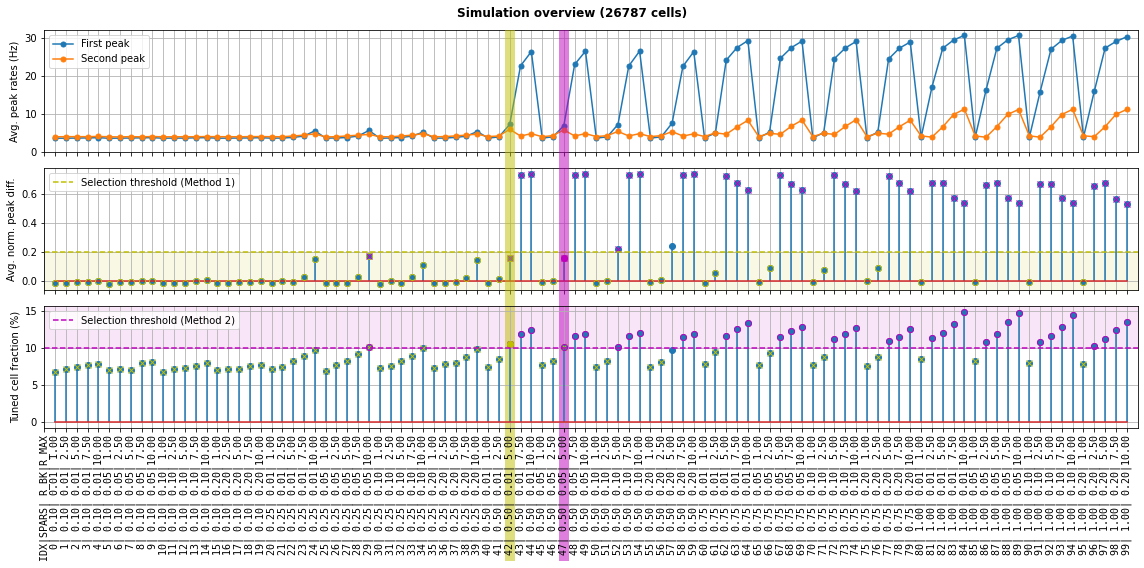

In [23]:
# Plot selected simulations
sel1_color = 'y'
sel2_color = 'm'
plt.figure(figsize=(16, 8))
peak_ratios = np.array([np.nanmean(peak_data[idx]['peak_ratio']) for idx in sim_ids])
peak_rates = np.array([[np.nanmean(peak_data[idx]['r1']), np.nanmean(peak_data[idx]['r2'])] for idx in sim_ids])
plt.subplot(3, 1, 1)

plt.plot(np.arange(len(peak_data)), peak_rates[:, 0], '.-', color=peak_colors[0], markersize=10, clip_on=False, label='First peak')
plt.plot(np.arange(len(peak_data)), peak_rates[:, 1], '.-', color=peak_colors[1], markersize=10, clip_on=False, label='Second peak')
plt.xlim([-1, len(peak_data)])
plt.ylim([0, max(plt.ylim())])
# plt.plot([sim_idx1] * 2, plt.ylim(), '-', color=sel1_color, linewidth=10, alpha=0.5, zorder=0)
# plt.plot([sim_idx2] * 2, plt.ylim(), '-', color=sel2_color, linewidth=10, alpha=0.5, zorder=0)

xticks = [min(plt.xlim())] + np.arange(len(peak_data)).tolist()
plt.xticks(xticks, [])
plt.ylabel('Avg. peak rates (Hz)')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.stem(np.arange(len(peak_data)), peak_ratios)
plt.xlim([-1, len(peak_data)])
plt.ylim(plt.ylim())
plt.plot(np.arange(len(peak_data))[peak_ratios < peak_ratio_th], peak_ratios[peak_ratios < peak_ratio_th], 'o', markerfacecolor='none', color=sel1_color)
plt.plot(np.arange(len(peak_data))[signif_pct > cell_pct_th], peak_ratios[signif_pct > cell_pct_th], 'x', markerfacecolor='none', color=sel2_color)
plt.plot(sim_idx2, peak_ratios[sim_idx2], 'o', color=sel2_color)
plt.plot(plt.xlim(), [peak_ratio_th] * 2, '--', color=sel1_color, label='Selection threshold (Method 1)')
plt.fill_between(plt.xlim(), [peak_ratio_th] * 2, [min(plt.ylim())] * 2, color=sel1_color, alpha=0.1, zorder=0)
# plt.plot([sim_idx1] * 2, plt.ylim(), '-', color=sel1_color, linewidth=10, alpha=0.5, zorder=0)
# plt.plot([sim_idx2] * 2, plt.ylim(), '-', color=sel2_color, linewidth=10, alpha=0.5, zorder=0)

xticks = [min(plt.xlim())] + np.arange(len(peak_data)).tolist()
plt.xticks(xticks, [])
plt.ylabel('Avg. norm. peak diff.')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.stem(np.arange(len(sim_ids)), signif_pct)
plt.xlim([-1, len(sim_ids)])
plt.ylim(plt.ylim())
plt.plot(np.arange(len(sim_ids))[peak_ratios < peak_ratio_th], signif_pct[peak_ratios < peak_ratio_th], 'x', markerfacecolor='none', color=sel1_color)
plt.plot(np.arange(len(sim_ids))[signif_pct > cell_pct_th], signif_pct[signif_pct > cell_pct_th], 'o', markerfacecolor='none', color=sel2_color)
plt.plot(sim_idx1, signif_pct[sim_idx1], 'o', color=sel1_color)
plt.plot(plt.xlim(), [cell_pct_th] * 2, '--', color=sel2_color, label='Selection threshold (Method 2)')
plt.fill_between(plt.xlim(), [cell_pct_th] * 2, [max(plt.ylim())] * 2, color=sel2_color, alpha=0.1, zorder=0)
# plt.plot([sim_idx1] * 2, plt.ylim(), '-', color=sel1_color, linewidth=10, alpha=0.5, zorder=0)
# plt.plot([sim_idx2] * 2, plt.ylim(), '-', color=sel2_color, linewidth=10, alpha=0.5, zorder=0)

plt.plot([sim_idx1] * 2, (-18, 52), '-', color=sel1_color, linewidth=10, alpha=0.5, zorder=0, clip_on=False)
plt.plot([sim_idx2] * 2, (-18, 52), '-', color=sel2_color, linewidth=10, alpha=0.5, zorder=0, clip_on=False)

head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_ids].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_ids[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_ids].index)]
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.ylabel('Tuned cell fraction (%)')
plt.grid()
plt.legend()

plt.suptitle(f'Simulation overview ({num_cells} cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'sim_sel_overview.png'), dpi=300)
plt.show()

In [27]:
assert False, 'STOP HERE'

AssertionError: STOP HERE

In [24]:
### OLD CODE ###

In [25]:
# Select cell population
sim_target = 'hex0'
cell_sel = {'synapse_class': 'EXC'} # 'layer': 4

# Select pattern (=contrast level) for peak statistics extraction
patt_sel = 1 # N patterns: 0..N-1 w/o opto, N..2N-1 with opto

# Specifier label
spec_label_base = '-'.join([f'{k}{v}' for k, v in cell_sel.items()])
spec_label_base = spec_label_base.replace('synapse_class', '')
spec_label_base = spec_label_base.replace('layer', 'L')
spec_label_base = '_'.join([sim_target, spec_label_base])
print(f'Specifier label: {spec_label_base}')

Specifier label: hex0_EXC


## Peak responses to drifting gratings

### Overview over all simulations

In [26]:
# Compute PSTHs and peak statistics for all simulations...
psth_res = 1.0 # (ms)
psth_smooth = 20.0 # (ms)
peak_th = 5.0
peak_width = 20.0
peak_distance = 200.0
peak_range = [0.0, 1000.0] # (ms)
psth_data = {}
peak_stats = {}
print(f'{sims.shape[0]} simulations ... PROCESSING', end='')
for idx in range(1): #range(sims.shape[0]):
    print(f' {idx + 1}', end='')
    t_rate, rates, spike_trains, avg_cell_rates, gids, stim_cfg, opto_cfg = get_single_cell_psths(sims.iloc[idx], {'target': sim_target, **cell_sel}, t_res=psth_res, t_smooth=psth_smooth)
    peak_idx, t1, t2, r1, r2, peak_ratio = detect_rate_peaks(t_rate, rates[patt_sel], peak_th=peak_th, peak_width=peak_width, peak_distance=peak_distance, t_range=peak_range)

    psth_data.update({idx: {'t_rate': t_rate, 'rates': rates, 'spike_trains': spike_trains, 'avg_cell_rates': avg_cell_rates, 'gids': gids, 'stim_cfg': stim_cfg, 'opto_cfg': opto_cfg}})
    peak_stats.update({idx: {'peak_idx': peak_idx, 't1': t1, 't2': t2, 'r1': r1, 'r2': r2, 'peak_ratio': peak_ratio}})

100 simulations ... PROCESSING 1

NameError: name 'get_single_cell_psths' is not defined

In [ ]:
# Write to pickled files
spec_label = spec_label_base
data_file = os.path.join(save_path, f'psth_data_{spec_label}.pickle')
with open(data_file, 'wb') as f:
    pickle.dump(psth_data, f)
print(f'INFO: PSTH data written to {data_file}')

spec_label = '_'.join([spec_label_base, f'P{patt_sel}'])
stats_file = os.path.join(save_path, f'peak_stats_{spec_label}.pickle')
with open(stats_file, 'wb') as f:
    pickle.dump(peak_stats, f)
print(f'INFO: Peak statistics written to {stats_file}')

In [ ]:
# # ...OR load from pickled files
# spec_label = spec_label_base
# data_file = os.path.join(save_path, f'psth_data_{spec_label}.pickle')
# with open(data_file, 'rb') as f:
#     psth_data = pickle.load(f)
# print('INFO: PSTH data successfully loaded')

# spec_label = '_'.join([spec_label_base, f'P{patt_sel}'])
# stats_file = os.path.join(save_path, f'peak_stats_{spec_label}.pickle')
# with open(stats_file, 'rb') as f:
#     peak_stats = pickle.load(f)
# print('INFO: Peak statistics successfully loaded')

In [ ]:
# Plot peak statistics overview
sim_idx = list(peak_stats.keys())
plt.figure(figsize=(16, 6))
peak_ratios = np.array([np.nanmean(peak_stats[idx]['peak_ratio']) for idx in sim_idx])
peak_rates = np.array([[np.nanmean(peak_stats[idx]['r1']), np.nanmean(peak_stats[idx]['r2'])] for idx in sim_idx])
plt.subplot(2, 1, 1)
# plt.plot([np.arange(len(peak_stats))] * 2, np.array(peak_rates).T, '.-')
plt.plot(np.arange(len(peak_stats)), peak_rates[:, 0], '.-', color='tab:blue', markersize=10, clip_on=False, label='First peak')
plt.plot(np.arange(len(peak_stats)), peak_rates[:, 1], '.-', color='tab:orange', markersize=10, clip_on=False, label='Second peak')
plt.xlim([-1, len(peak_stats)])
xticks = [min(plt.xlim())] + np.arange(len(peak_stats)).tolist()
plt.xticks(xticks, [])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Avg. peak rates (Hz)')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.stem(np.arange(len(peak_stats)), peak_ratios)
plt.xlim([-1, len(peak_stats)])
head_label = ['|'.join(['IDX'] + [f'{n.upper().replace("RATE", "R")[:5]:>5}' for n in sims.iloc[sim_idx].index.names[:3]])]
idx_labels = ['|'.join([f'{sim_idx[idx]:3}'] + [f'{i:5.2f}' for i in val[:3]]) for idx, val in enumerate(sims.iloc[sim_idx].index)]
plt.xticks(xticks, head_label + idx_labels, rotation=90, font='monospace')
plt.ylabel('Avg. norm. peak difference')
plt.grid()

plt.suptitle(f'Peak statistics overview ({len(peak_stats[sim_idx[0]]["peak_ratio"])} cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'peak_stats_overview_{spec_label}.png'), dpi=300)
plt.show()

In [ ]:
# Plot histogram
num_bins = 20
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(peak_rates, bins=num_bins)
plt.grid()
plt.gca().set_axisbelow(True)
plt.xlabel('Avg. peak rates')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(peak_ratios, bins=num_bins)
plt.grid()
plt.gca().set_axisbelow(True)
plt.xlabel('Avg. norm. peak difference')
plt.ylabel('Count')

plt.suptitle(f'Mean peak statistics over {len(peak_stats)} simulations', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'peak_stats_hist_{spec_label}.png'), dpi=300)
plt.show()

### Detailed results of selected simulations

In [ ]:
sim_sel = 0
assert sim_sel in psth_data.keys() and sim_sel in peak_stats.keys(), f'ERROR: No peak statistics available for simulation {sim_sel}!'
spec_label = '_'.join([f'SIM{sim_sel}', spec_label_base])

In [ ]:
# PSTHs of selected (strongly firing) cells
count_sel = 20 # Number of cells to select (based on average firing rates)

y_scale_range = 0.9
y_rate_scale = y_scale_range / np.nanmax(rates)
y_trial_scale = y_scale_range / (np.max([[len(spike_trains[p][gid]) for gid in spike_trains[p].keys()] for p in range(len(spike_trains))]) - 1)

spike_trains = psth_data[sim_sel]['spike_trains']
avg_cell_rates = psth_data[sim_sel]['avg_cell_rates']
t_rate = psth_data[sim_sel]['t_rate']
rates = psth_data[sim_sel]['rates']
gids = psth_data[sim_sel]['gids']

# Filter & sort GIDs by increasing average firing rates over all patterns
num_patterns = len(avg_cell_rates)
avg_rates_sel = np.nanmean(avg_cell_rates, 0)
sort_idx = np.argsort(avg_rates_sel)[::-1] # Ordered by decreasing rate
sel_idx = sort_idx[:count_sel] # Selecting count_sel gids
gids_sel = gids[sel_idx]

plt.figure(figsize=(5 * num_patterns, 5))
for p in range(num_patterns):
    rates_sel = rates[p][sel_idx, :]
    plt.subplot(1, num_patterns, p + 1)
    for gidx, gid in enumerate(gids_sel):
        trials = spike_trains[p][gid]
        y_offset = len(gids_sel) - 1 - gidx - y_scale_range / 2
        for trial, st in enumerate(trials):
            plt.plot(st, np.full(len(st), trial * y_trial_scale + y_offset), '.k', markersize=2.0, markeredgecolor='none')
        plt.plot(t_rate, rates_sel[gidx, :] * y_rate_scale + y_offset, 'r-')
    plt.yticks(np.arange(len(gids_sel)), gids_sel[::-1])
    plt.ylim((-1, len(gids_sel)))
    plt.xlabel('Time (ms)')
    plt.ylabel('GID')
    if p < num_patterns >> 1:
        plt.title(f'Pattern {p}')
    else:
        plt.title(f'Pattern {p - (num_patterns >> 1)}-OPTO')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_spikes_{spec_label}.png'), dpi=300)
plt.show()

In [ ]:
# Plot instantaneous firing rates (overview map)
plt.figure(figsize=(5 * num_patterns, 5))
t_res = np.median(np.diff(t_rate))
for p in range(num_patterns):
    plt.subplot(1, num_patterns, p + 1)
    plt.imshow(rates[p][sort_idx, :], extent=(t_rate[0] - 0.5 * t_res, t_rate[-1] + 0.5 * t_res, rates[p].shape[0] - 0.5, -0.5), aspect='auto', interpolation='nearest')
    plt.colorbar(label='Firing rate (Hz)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Cells (sorted)')
    if p < num_patterns >> 1:
        plt.title(f'Pattern {p}')
    else:
        plt.title(f'Pattern {p - (num_patterns >> 1)}-OPTO')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rates_{spec_label}.png'), dpi=300)
plt.show()

In [ ]:
# Plot peak statistics (exemplary GIDs)
gids_idx_sel = [0, 1, 2] # Selection indices of sorted gids

spec_label = '_'.join([f'SIM{sim_sel}', spec_label_base, f'P{patt_sel}'])

t1 = peak_stats[sim_sel]['t1']
t2 = peak_stats[sim_sel]['t2']
r1 = peak_stats[sim_sel]['r1']
r2 = peak_stats[sim_sel]['r2']
peak_ratio = peak_stats[sim_sel]['peak_ratio']

for idx_sel in gids_idx_sel:
    plt.figure(figsize=(10, 1))
    plt.plot(t_rate, rates[patt_sel][sort_idx[idx_sel], :], 'k')
    plt.plot(t1[sort_idx[idx_sel]], r1[sort_idx[idx_sel]], 'x', color='tab:blue', markersize=10, clip_on=False, label='First peak')
    plt.plot(t2[sort_idx[idx_sel]], r2[sort_idx[idx_sel]], 'x', color='tab:orange', markersize=10, clip_on=False, label='Second peak')
    plt.ylim(plt.ylim())
    gid = gids[sort_idx[idx_sel]]
    trials = spike_trains[patt_sel][gid]
    y_scale = np.diff(plt.ylim()) / len(trials)
    for trial, st in enumerate(trials):
        plt.plot(st, np.full(len(st), (trial - 0.5 * (len(trials) - 1)) * y_scale + np.mean(plt.ylim())), '|g', markersize=5.0)
    plt.grid()
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing rate (Hz)')
    plt.title(f'GID {gid} (peak_ratio={peak_ratio[sort_idx[idx_sel]]:.3})', fontweight='bold')
    plt.legend(loc='upper left', bbox_to_anchor=[1.0, 1.0])
    plt.savefig(os.path.join(save_path, f'psth_rate_peaks_{spec_label}_GID{gid}.png'), dpi=300)
plt.show()

In [ ]:
# Plot instantaneous firing rates inkl. peaks (all GIDs for which peak_ratio is defined)
gid_sel = np.isfinite(peak_ratio)
plt.figure(figsize=(8, 3))
plt.plot(t_rate, rates[patt_sel].T, 'k', alpha=0.25)
for idx in range(np.sum(gid_sel)):
    plt.plot(np.array(t1)[gid_sel][idx], np.array(r1)[gid_sel][idx], 'x', color='tab:blue', alpha=1.0, label='First peak' if idx == 0 else None)
    plt.plot(np.array(t2)[gid_sel][idx], np.array(r2)[gid_sel][idx], 'x', color='tab:orange', alpha=1.0, label='Second peak' if idx == 0 else None)
plt.grid()
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.title(f'PSTH peak overview ({np.sum(gid_sel)} of {len(gid_sel)} cells)', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rate_peaks_{spec_label}.png'), dpi=300)
plt.show()

# Plot first vs. second peak
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
num_bins = 50
plt.hist(np.array(t1)[gid_sel], bins=np.linspace(0, np.max([np.array(t1)[gid_sel], np.array(t2)[gid_sel]]), num_bins + 1), width=1.0 * np.max([np.array(t1)[gid_sel], np.array(t2)[gid_sel]]) / num_bins, label='First')
plt.hist(np.array(t2)[gid_sel], bins=np.linspace(0, np.max([np.array(t1)[gid_sel], np.array(t2)[gid_sel]]), num_bins + 1), width=1.0 * np.max([np.array(t1)[gid_sel], np.array(t2)[gid_sel]]) / num_bins, label='Second')
plt.grid()
plt.xlabel('Peak time (ms)')
plt.ylabel('Count')
plt.title('Peak time histograms')
plt.legend()

plt.subplot(1, 4, 2)
num_bins = 25
plt.hist([np.array(r1)[gid_sel], np.array(r2)[gid_sel]], bins=num_bins, label=['First', 'Second'])
plt.grid()
plt.xlabel('Peak rate (Hz)')
plt.ylabel('Count')
plt.title('Peak rate histograms')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(r1, r2, '.', color='tab:purple')
plt.xlim([0, np.max([np.array(r1)[gid_sel], np.array(r2)[gid_sel]])])
plt.ylim([0, np.max([np.array(r1)[gid_sel], np.array(r2)[gid_sel]])])
plt.plot([min(plt.xlim()), max(plt.xlim())], [min(plt.ylim()), max(plt.ylim())], '--k', zorder=0)
plt.grid()
plt.xlabel('First peak rate (Hz)')
plt.ylabel('Second peak rate (Hz)')
plt.title('First vs. second peak rate')

plt.subplot(1, 4, 4)
num_bins = 25
plt.hist(peak_ratio, bins=num_bins, color='tab:purple')
plt.ylim(plt.ylim())
plt.plot(np.zeros(2), plt.ylim(), '--k')
plt.plot(np.full(2, np.nanmean(peak_ratio)), plt.ylim(), '-', color='tab:green', linewidth=3)
plt.text(np.nanmean(peak_ratio), 0.99 * max(plt.ylim()), f'  Mean: {np.nanmean(peak_ratio):.3f}', color='tab:green', ha='left', va='top')
plt.grid()
plt.xlabel('Norm. peak difference')
plt.ylabel('Count')
plt.title('First vs. second peak ratio')

plt.suptitle(f'PSTH peak statistics ({np.sum(gid_sel)} of {len(gid_sel)} cells)', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_peak_stats_{spec_label}.png'), dpi=300)
plt.show()

In [ ]:
# TODO => Characterization of grating stimulus responses:
# * Select set of (EXC/INH) cells, (strongly) responding to max. contrast
# * For each single cell, characterize responses:
#   - From instantaneous rates: Peak rates of 1st (highest) peak => To select stimulus parameters
#   - From instantaneous rates: Ratio of 1st (highest) vs. 2nd (2nd highest) peak rates => To select stimulus parameters
#     => MORE ROBUST by selecting first two HIGHEST peaks?? => YES (i.e., peak detection settings can be relaxed)
#     => LOOK AT medium/low responding cells as well
#     => PLOT 1st AND 2nd peak rate vs. Sim IDX
#   - Average rate over blank intervals => Baseline
#   - Average rate over stim intervals (different contrast) => Tuning curves (control, i.e. w/o opto stim)
#
# * For INH cells, check if/why shape of (PV) response is different from [Shapiro et al. 2021]

# IDEA: Plot 2D map of peak ratios

In [ ]:
# TODO: EXC peak statistics
#       EXC/INH tuning

In [ ]:
# # Population PSTHs
# for idx in [0, 4, 15, 19, 80, 84, 95, 99]:
#     blue_config = sims.iloc[idx]
#     plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_{idx}.png'))